In [92]:
# Import libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
# from xgboost import XGBClassifier
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from wordcloud import STOPWORDS # need to update with more
import re
from matplotlib import style
style.use('ggplot')
stop_words = set(stopwords.words('english'))
import warnings
warnings.filterwarnings('ignore')

### **Data Acquisition**
- The dataset was gotten from kaggle and here is a brief summary of the datasets:
    - [*IMDB dataset*]([https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews]) having 50K movie reviews for natural language processing or Text analytics.This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training and 25,000 for testing. So, predict the number of positive and negative reviews using either classification or deep learning algorithms.

In [93]:
# Load datasets
imbd_reviews = pd.read_csv('./IMDB Dataset.tar.xz')

### Data Processing and Cleaning

- The data was imported successfully, and a ratio was gotten to see how balanced the data was.
- A plot was made to show the ratio graphically
- The `word_count` function was defined and used to count the individual words in each row of reviews
- New column for word count was created using the `word_count` function 
- The positive and negative review were encoded in 0s and 1s for better processing
- The `data_processing` function was defined and it used regular expression to remove noise from each row of reviews  in the data set
- The `stemming` function was created to stem each token from the review column
- Stemming was also carried out on the reviews column in order to simplify the words in the reviews column and its original values were replaced.
- The Tfidf vectorizer was used to normalize and generate a sparse matrix that can be fed into the machine learning model
- 

In [94]:
# Ratio of Positive and Negative Sentiment
imbd_reviews['sentiment'].value_counts(normalize=True)

sentiment
positive    0.5
negative    0.5
Name: proportion, dtype: float64

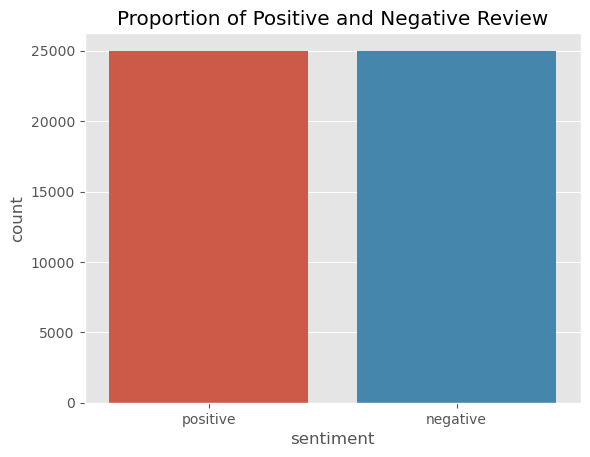

In [95]:
# Plot of Sentiment
sns.countplot(data=imbd_reviews, x='sentiment', hue='sentiment').set(title='Proportion of Positive and Negative Review')
plt.show()

In [96]:
# Counts the words in each column of review text
def word_count(text: str) -> int:
    return len(text.split())


In [97]:
# Get the word count for each review in the data set
imbd_reviews['word_count'] = imbd_reviews['review'].apply(word_count)

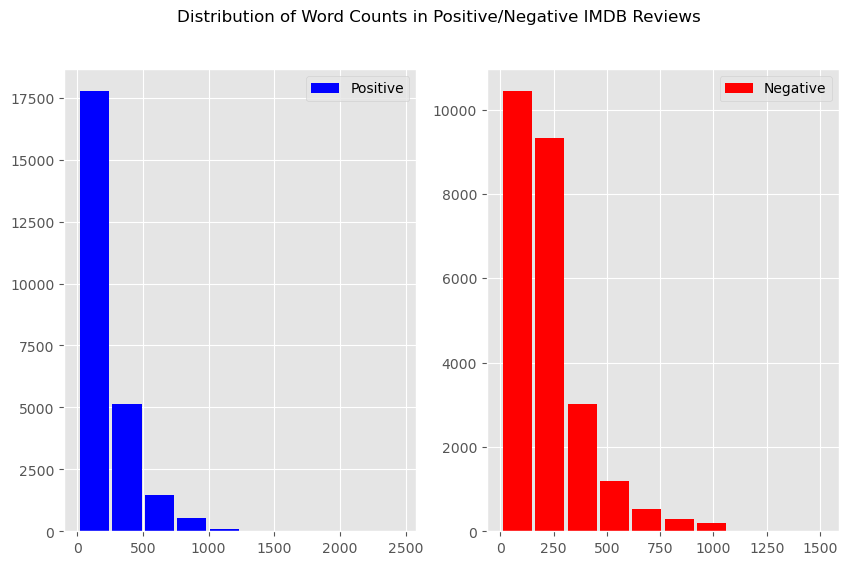

In [98]:
# Graph to show the distribution of positive and negative reviews of word count
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].hist(imbd_reviews[imbd_reviews['sentiment'] == 'positive']['word_count'], label='Positive', color='blue', rwidth=0.9);
ax[0].legend(loc="upper right")
ax[1].hist(imbd_reviews[imbd_reviews['sentiment'] == 'negative']['word_count'], label='Negative', color='red', rwidth=0.9)
ax[1].legend(loc='upper right')
fig.suptitle('Distribution of Word Counts in Positive/Negative IMDB Reviews')
plt.show();

In [99]:
# Encoding Sentiment and Freshness with 0s and 1s
st_dict = {
    'positive': 1,
    'negative': 0
}
# Imbd Sentiment replacement
imbd_reviews['sentiment'].replace(st_dict, inplace=True)

In [100]:
# Update stop words with more words
stop_words.update(['movie', 'movies', 'films', 'film'])

# function that processes data by removing stop words, punctuation, and tokenizing the words
def data_processing(text: str) -> str:
    text = text.lower()
    text = re.sub('<br />', '', text)
    text = re.sub(r"https\S+|www|S+|http\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if w not in stop_words]
    return " ".join(filtered_text)

In [101]:
# Apply data processing function to review column
imbd_reviews['review'] = imbd_reviews['review'].apply(data_processing)

In [102]:
# Check for duplicates and drop duplicates
imdb_duplicated = imbd_reviews.duplicated().sum()

print(f"Duplicated entries in imbd reviews: {imdb_duplicated}")

# Drop duplicates from imbd_reviews
imbd_reviews = imbd_reviews.drop_duplicates()

Duplicated entries in imbd reviews: 421


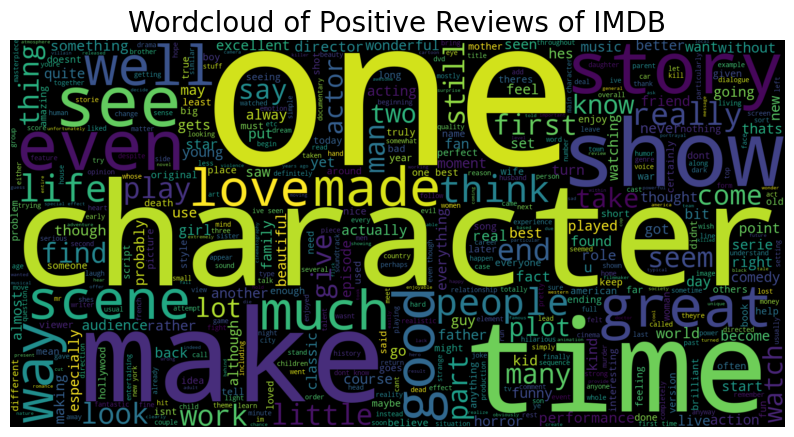

In [103]:
# Wordcloud of positive reviews of IMDB
positive_reviews = imbd_reviews[imbd_reviews['sentiment'] == 1]
positive_reviews = positive_reviews['review']
text = " ".join(review for review in positive_reviews)
plt.figure(figsize=(10, 6), facecolor=None)
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of Positive Reviews of IMDB', fontsize=20)
plt.show()

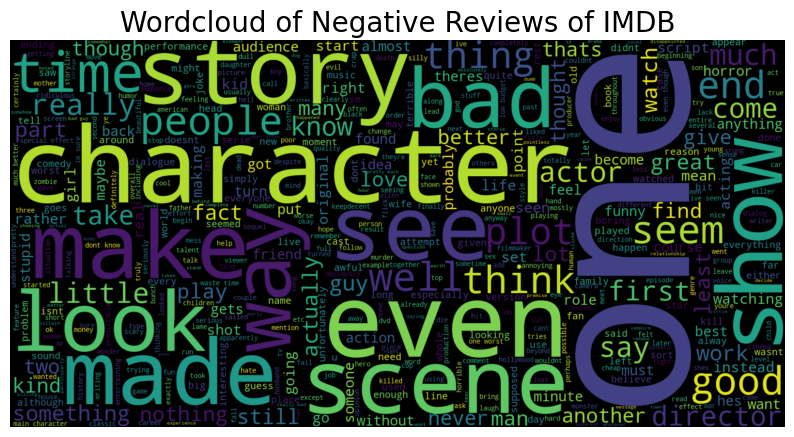

In [104]:
# Wordcloud of negative reviews of IMDB
negative_reviews = imbd_reviews[imbd_reviews['sentiment'] == 0]
negative_reviews = negative_reviews['review']
text = " ".join(review for review in negative_reviews)
plt.figure(figsize=(10, 6), facecolor=None)
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of Negative Reviews of IMDB', fontsize=20)
plt.show()

In [105]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to stem the words in the data set
def stemming(data: str) -> str:
    tokens = word_tokenize(data.lower())
    stemmed = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed)

In [106]:
# Apply stemming function to review column in imbd_reviews
imbd_reviews['review'] = imbd_reviews['review'].apply(stemming)

#### Model Building

In [107]:
# Initialize the vectorizer
tfidf_imbd = TfidfVectorizer()  
# Fit and transform the vectorizer on the imbd_reviews data set
X_imdb = tfidf_imbd.fit_transform(imbd_reviews['review'])


In [108]:
# train test split for imbd_reviews
X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb = train_test_split(X_imdb, imbd_reviews['sentiment'], 
                                                                        test_size=0.2, random_state=42)

In [109]:
# Naive model accuracy for IMDB
imdb_naive_model = accuracy_score(y_train_imdb, [1 for _ in range(len(y_train_imdb))])
print(f"Naive model accuracy for IMDB: {imdb_naive_model*100}") # type: ignore

Naive model accuracy for IMDB: 50.112195244938604


In [110]:
# Logistic Regression model for IMDB
imdb_logreg = LogisticRegression()
imdb_logreg.fit(X_train_imdb, y_train_imdb)

LogisticRegression()

In [111]:
# Score for Logistic Regression model for IMDB
imdb_logreg_test_score = imdb_logreg.score(X_test_imdb, y_test_imdb)
print(f"Logistic Regression model accuracy for IMDB: {imdb_logreg_test_score*100}")

Logistic Regression model accuracy for IMDB: 89.31020572811617


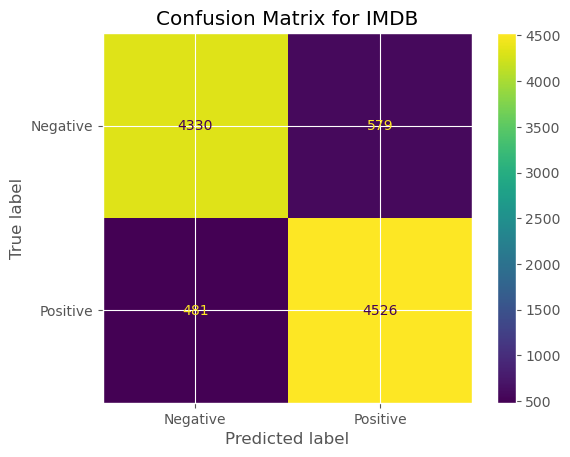

In [112]:
# ConfusionMatrixDisplay for IMDB
imdb_confusion_matrix = confusion_matrix(y_test_imdb, imdb_logreg.predict(X_test_imdb))
imdb_confusion_matrix_display = ConfusionMatrixDisplay(imdb_confusion_matrix, display_labels=['Negative', 'Positive'])
imdb_confusion_matrix_display.plot()
plt.title('Confusion Matrix for IMDB')
plt.show()

In [113]:
# pickle the model and save it
import pickle
pickle.dump(imdb_logreg, open('imdb_logreg.pkl', 'wb'))

In [114]:
# List of positive and negative reviews for Toy Story
pos_reviews = ["Toy Story brought my childhood back to life! The animation is timeless, the story is heartwarming, and the characters are unforgettable. Pixar never disappoints!",
               "I laughed so hard my sides hurt during Toy Story! Buzz Lightyear's heroic delusions are pure comedy gold, and Woody's loyalty to Andy is genuinely touching. A classic for all ages!",
               "Toy Story was a game-changer in animation. The vibrant colors, the expressive characters, the imaginative world - it felt like stepping into a toy box come to life. A must-watch for anyone who loves a good story.",
               "I could cry every time I watch Andy leaving for college in Toy Story 2. The emotional depth of these toys is incredible, and their struggle to hold onto their purpose is relatable to anyone who's ever grown up.",
               "Toy Story 3 is a masterpiece of storytelling. It's funny, it's touching, it's nostalgic, and it reminds us that growing up doesn't mean forgetting what's truly important. A perfect send-off for these beloved characters."]

neg_reviews = ["Toy Story had some good visuals, but the story felt predictable and the characters weren't very deep. I'm not sure why all the hype.",
               "The humor in Toy Story fell flat for me. Most of the jokes were aimed at kids, and the slapstick didn't do much for me. I expected more from Pixar.",
               "I found the portrayal of Woody as controlling and manipulative in Toy Story 2 to be unsettling. It doesn't send a great message about friendship and loyalty.",
               "Toy Story 3 left me feeling sad and confused. The whole 'grown-up toys being forgotten' thing was pretty depressing, and the ending felt rushed.",
               "I didn't care for the new characters in Toy Story 4. They didn't have the same charm as the originals, and the story felt like a rehash of what we'd already seen."]

In [115]:
# function that iterates through the list of reviews and returns the sentiment of each review
def sentiment_analysis(reviews: list) -> list:
    reviews = [data_processing(review) for review in reviews]
    reviews = [stemming(review) for review in reviews]
    reviews = tfidf_imbd.transform(reviews) # type: ignore
    return imdb_logreg.predict(reviews) # type: ignore


In [116]:
# Display the sentiment of each review in Positve Reviews
for review in pos_reviews:
    print(f"Review: {review}")
    if sentiment_analysis([review]) == 1:
        print("Sentiment: Positive Review")
    else:
        print("Sentiment: Negative Review")
    print()

Review: Toy Story brought my childhood back to life! The animation is timeless, the story is heartwarming, and the characters are unforgettable. Pixar never disappoints!
Sentiment: Positive Review

Review: I laughed so hard my sides hurt during Toy Story! Buzz Lightyear's heroic delusions are pure comedy gold, and Woody's loyalty to Andy is genuinely touching. A classic for all ages!
Sentiment: Positive Review

Review: Toy Story was a game-changer in animation. The vibrant colors, the expressive characters, the imaginative world - it felt like stepping into a toy box come to life. A must-watch for anyone who loves a good story.
Sentiment: Positive Review

Review: I could cry every time I watch Andy leaving for college in Toy Story 2. The emotional depth of these toys is incredible, and their struggle to hold onto their purpose is relatable to anyone who's ever grown up.
Sentiment: Positive Review

Review: Toy Story 3 is a masterpiece of storytelling. It's funny, it's touching, it's nos

In [117]:
# Display the sentiment of each review in Negative Reviews
for review in neg_reviews:
    print(f"Review: {review}")
    if sentiment_analysis([review]) == 1:
        print("Sentiment: Positive Review")
    else:
        print("Sentiment: Negative Review")
    print()

Review: Toy Story had some good visuals, but the story felt predictable and the characters weren't very deep. I'm not sure why all the hype.
Sentiment: Negative Review

Review: The humor in Toy Story fell flat for me. Most of the jokes were aimed at kids, and the slapstick didn't do much for me. I expected more from Pixar.
Sentiment: Negative Review

Review: I found the portrayal of Woody as controlling and manipulative in Toy Story 2 to be unsettling. It doesn't send a great message about friendship and loyalty.
Sentiment: Positive Review

Review: Toy Story 3 left me feeling sad and confused. The whole 'grown-up toys being forgotten' thing was pretty depressing, and the ending felt rushed.
Sentiment: Negative Review

Review: I didn't care for the new characters in Toy Story 4. They didn't have the same charm as the originals, and the story felt like a rehash of what we'd already seen.
Sentiment: Negative Review



### Summary of Project

**Introduction:**

My project explored the sentiment of movie reviews in the IMDb dataset using techniques from text analysis and machine learning. This document serves as a detailed explanation of the key steps involved, highlighting my contributions and the significance of each stage.

**Data Acquisition and Exploration:**

1. **Data Import:** I successfully imported the IMDb dataset, ensuring proper data access and manipulation.
2. **Balance Analysis:** I calculated and visualized the ratio of positive to negative reviews, providing insights into the data's class distribution. This information aids in understanding potential biases and model performance.

**Text Preprocessing:**

1. **`word_count` Function:** I defined a function to count the number of words in each review, adding a new "word_count" column to the DataFrame. This feature can be informative for sentiment analysis, potentially revealing differences in review lengths between positive and negative opinions.
2. **Label Encoding:** Positive and negative reviews were transformed into numeric labels (0s and 1s) for efficient processing by machine learning algorithms. This simplifies the target variable for model training and prediction.
3. **`data_processing` Function:** I developed a dedicated function utilizing regular expressions to remove noise from reviews. This step eliminates unwanted characters and punctuation, focusing the analysis on meaningful textual content.
4. **Stemming:** A custom `stemming` function was created to reduce each word in the "reviews" column to its base form. This reduces data sparsity and improves model generalization by grouping similar words under a common stem, effectively capturing the core meaning without relying on exact word matches.

**Feature Engineering and Modeling:**

1. **TF-IDF Vectorizer:** I employed TF-IDF Vectorizer to transform the preprocessed reviews into a numerical representation suitable for machine learning. This technique considers both term frequency (word occurrences) and inverse document frequency (word rarity across the corpus), creating a more informative feature space for sentiment analysis.
2. **Logistic Regression Model:** I built a Logistic Regression model to predict the sentiment of each review. This well-established algorithm is suitable for binary classification tasks and interpretable for understanding the features influencing its predictions.

**User Interaction and Visualization:**

1. **`sentiment_analysis` Function:** I developed a function that accepts a list of reviews and predicts their sentiment. This allows users to easily analyze any new review through the trained model.
2. **WordCloud Visualization:** I generated a WordCloud to showcase the most frequent words in the dataset. This visualizes the dominant vocabulary used in both positive and negative reviews, offering insights into common themes and linguistic patterns.
3. **Confusion Matrix:** I constructed a confusion matrix to analyze the model's performance. This matrix reveals how accurately the model classifies positive and negative reviews, highlighting areas for potential improvement in future iterations.

**Conclusion:**

This project demonstrates a comprehensive approach to sentiment analysis on movie reviews using data preprocessing, feature engineering, machine learning, and visual communication. The implemented techniques highlight the importance of text cleaning, feature representation, and model evaluation for achieving accurate and insightful sentiment prediction. This framework can be extended to analyze other text datasets and explore different machine learning algorithms to further enhance sentiment analysis performance.